

























































In this notebook we use segmentation of each time point to make translational corrections of each nuclei in the field of view. At the end of this script we obtain crop of each nuclei along with the translational corrections over the length of the movie

In [1]:
import os
import numpy as np


from copy import deepcopy
from dask.array.image import imread as imr
import bigfish.stack as stack
from bigfish.multistack import match_nuc_cell

from cellpose import models
from cellpose.utils import remove_edge_masks
from cellpose.io import imread, save_to_png, masks_flows_to_seg

import tkinter as tk
from tkinter import filedialog

from cropFunctions import *
from tqdm import tqdm
from joblib import Parallel, delayed
import time
from pathlib import Path
import matplotlib.pyplot as plt
import tifffile

In [3]:
start_time = time.time()

os.chdir(os.getcwd())

def choose_home_folder(title):
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askdirectory(initialdir= "/", title=title)  # Open file dialog
    root.destroy()  # Close the tkinter window
    return file_path

def choose_file(title='Please select a file'):
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(initialdir= "/", title=title)  # Open file dialog
    root.destroy()  # Close the tkinter window
    return file_path

def createMask(timep, movieFile, filename):
    filename = filename+str(f"_t{timep:03}")
    imageFile = movieFile[timep]
    imgs = np.max(imageFile, axis=0)

    # channels = [[0,0]]
    masks, flows, styles = liveCellModel.eval(imgs, diameter=None, channels=[[0,0]])
    # masks_flows_to_seg(imgs, masks, flows, filename, 1, channels)
    save_to_png(imgs, masks, flows, filename)



liveCellModel = models.CellposeModel(pretrained_model=choose_file('Select live cell segmentation model'))

identifier = 'basal'

homeFolder = choose_home_folder('Select folder with sessions')

print("Chosen home folder:", homeFolder)
sessionNames = [os.path.join(homeFolder,i) for i in os.listdir(homeFolder) if identifier in i and os.path.isdir(os.path.join(homeFolder,i))]
sessionNames.sort()
sessionNames


Chosen home folder: C:/Users/uid-1204/Desktop/test2_bigFISHLIVE


['C:/Users/uid-1204/Desktop/test2_bigFISHLIVE\\Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06']

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [11:31<00:00,  1.30it/s]


2111.4821994304657


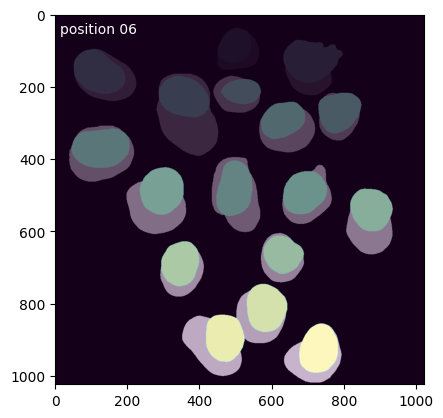

In [4]:

# ## Load cellpose model 

for i in sessionNames:
    i=Path(i)
    moviePath=i
    imsQ = i.name.split('_F')[-1]
    imageName = i.name
    movieExtension = '.tif'
    maskFolder = os.path.join(homeFolder,'tProjections')
    maskpath = os.path.join(maskFolder,'T_MAX_'+imageName.replace('.','_')+'_cp_masks.png')
    maskImageAll = imread(maskpath)
    pathToTimeFrames = os.path.join(moviePath,'*.tif')

    movieFile = imr(pathToTimeFrames)
    tempmaskFolder = os.path.join(i, 'tempMasks')

    # Make Masks

    filename = os.path.join(tempmaskFolder,imageName.replace('.','_'))
    Parallel(n_jobs=8)(delayed(createMask)(timepoints,movieFile, filename) for timepoints in tqdm(range(len(movieFile))))


    for timep in tqdm(range(len(movieFile))):

        imageFile = movieFile[timep]

        #------------------ Load T projection --------------------#

        ## T projection mask 

        maskpath = os.path.join(maskFolder,'T_MAX_'+imageName.replace('.','_')+'_cp_masks.png')
        maskImageAll = imread(maskpath)
        labelImageAll = label(maskImageAll)
        new_Proj_label = remove_edge_masks(labelImageAll, change_index=True)
        new_Proj_label2 = deepcopy(new_Proj_label)
        noNucleiA = np.unique(new_Proj_label)
        noNucleiA = np.delete(noNucleiA,np.where(noNucleiA == 0))


        centroidListProjection = []
        coordsNuc = getCentroidAndOrientationImage(new_Proj_label)

        centroidLabelDF_Projection = makeParameterDf(coordsNuc)
        centroidLabelDF_Projection['sizex'] = np.max([centroidLabelDF_Projection['maxr'].apply(np.ceil)-centroidLabelDF_Projection['minr'].apply(np.floor),centroidLabelDF_Projection['maxc'].apply(np.ceil)-centroidLabelDF_Projection['minc'].apply(np.floor)], axis=0)
        centroidLabelDF_Projection['sizey'] = np.max([centroidLabelDF_Projection['maxr'].apply(np.ceil)-centroidLabelDF_Projection['minr'].apply(np.floor),centroidLabelDF_Projection['maxc'].apply(np.ceil)-centroidLabelDF_Projection['minc'].apply(np.floor)], axis=0)
        sizeList = pd.DataFrame(centroidLabelDF_Projection[['label','sizex', 'sizey']], dtype=np.int64)


        ## -------------- New masks (edge objects removed)-------------------

        ## load mask for frame t
        
        maskPathHome = os.path.join(tempmaskFolder,imageName.replace('.','_'))+str(f"_t{timep:03}")+'_cp_masks.png'
        if os.path.isfile(maskPathHome):
            
            imageMaskt = imread(maskPathHome)
            labelImaget = label(imageMaskt)
            new_t_label = remove_edge_masks(labelImaget, change_index=True)
    
    
            ## Match  
    
            ## Match  nucleus at frame t to projection.
    
            newLablet, newLableAll = match_nuc_cell(new_t_label, new_Proj_label, single_nuc=True, cell_alone=False)
            
            noNucleiAfterMatch = np.unique(newLableAll)
            noNucleiAfterMatch = np.delete(noNucleiAfterMatch,np.where(noNucleiAfterMatch == 0))
            if noNucleiAfterMatch.size!=0:
        
                test_t = getCentroidAndOrientationImage(newLablet)
                test_p = getCentroidAndOrientationImage(newLableAll)
        
                centroidLabelDF_t = makeParameterDf(test_t)
                centroidLabelDF_p = makeParameterDf(test_p)
        
                # new matched labels
        
                centroidLabelDF_p['newLabel'] = 0
                centroidLabelDF_t['newLabel'] = 0
                for iii in range(len(centroidLabelDF_p)):
                    dist = (centroidLabelDF_Projection['x']-centroidLabelDF_p['x'][iii])**2+(centroidLabelDF_Projection['y']-centroidLabelDF_p['y'][iii])**2
                    newLabel = centroidLabelDF_Projection.iloc[np.argmin(dist)]['label']
            #         newLabel = centroidLabelDF_Projection.iloc[np.argmin(np.abs(centroidLabelDF_Projection['diff']-centroidLabelDF_p['diff'][iii])),2]
                    centroidLabelDF_p.iloc[iii,9] = newLabel
                    idxs = np.where(centroidLabelDF_t.iloc[:,2]==centroidLabelDF_p['label'][iii])[0][0]
                    centroidLabelDF_t.iloc[idxs,9] = newLabel
            #     centroidLabelDF_t.sort_values(by=['label']).iloc[:,9] = centroidLabelDF_p.sort_values(by=['label'])['newLabel'].values
        
                #---------------------- Find Mismatch and Relabel -------------------------#
        
                ## Relabel Mismatched Nuclei
        
                mismatches = centroidLabelDF_t[centroidLabelDF_t.iloc[:,2]!=centroidLabelDF_t.iloc[:,9]]
                mismatchesp = centroidLabelDF_p[centroidLabelDF_p.iloc[:,2]!=centroidLabelDF_p.iloc[:,9]]
    
        
                # relabel wrong masks
        
                for ff, ffp in zip(mismatches.index, mismatchesp.index):
                    newLablet[np.where(newLablet == centroidLabelDF_t.iloc[ff,2])] *=-1
                    newLableAll[np.where(newLableAll == centroidLabelDF_t.iloc[ff,2])] *=-1
        
                # assign correct labels
        
                for ff, ffp in zip(mismatches.index, mismatchesp.index):
                    newLablet[np.where(newLablet == centroidLabelDF_t.iloc[ff,2]*-1)] = centroidLabelDF_t.iloc[ff,9]
                    newLableAll[np.where(newLableAll == centroidLabelDF_p.iloc[ffp,2]*-1)] = centroidLabelDF_p.iloc[ffp,9]
        
                noNucleiFinal = np.unique(newLableAll)
                noNucleiFinal = np.delete(noNucleiFinal,np.where(noNucleiFinal == 0))
        
                test_tCorr = getCentroidAndOrientationImage(newLablet)
                test_pCorr = getCentroidAndOrientationImage(newLableAll)
        
                centroidLabelDF_tCorr = makeParameterDf(test_tCorr)
                centroidLabelDF_pCorr = makeParameterDf(test_pCorr)
        
                # ---------------------- Plot Results ----------------------------------#
                if timep==0:
                    shouldIplot=True
                else:
                    shouldIplot=False
        
                if shouldIplot==True:
                    fig, ax = plt.subplots()
                    ax.imshow(newLableAll, cmap=plt.cm.gray)
                    ax.imshow(newLablet, alpha=0.3)
                    ax.text(15,50,'position '+imsQ, color='white')
                
                for kk in noNucleiFinal:
                    
                    if kk in noNucleiFinal:
                        yt = centroidLabelDF_tCorr.loc[centroidLabelDF_tCorr['label']==kk]['x'].values[0]
                        xt = centroidLabelDF_tCorr.loc[centroidLabelDF_tCorr['label']==kk]['y'].values[0]
                        nuc = centroidLabelDF_tCorr.loc[centroidLabelDF_tCorr['label']==kk]['label'].values[0]
        
        
                        y00 = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuc].x.values[0]
                        x00 = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuc].y.values[0]
        
                        # maxcc = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuc]['maxRef']
                        minr = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuc]['minr'].values[0]
                        minc = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuc]['minc'].values[0]
                        maxr = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuc]['maxr'].values[0]
                        maxc = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuc]['maxc'].values[0]
        
                        bx0 = (minc, maxc, maxc, minc, minc)
                        by0 = (minr, minr, maxr, maxr, minr)
        
                        maxccREf = np.max([abs(minr-maxr), abs(minc-maxc)])
                        np.round(maxccREf)//2
                        nminc_ = xt-np.round(maxccREf)//2
                        nminr_ = yt-np.round(maxccREf)//2
                        nmaxc_ = xt+np.round(maxccREf)//2
                        nmaxr_ = yt+np.round(maxccREf)//2
        
                        bxt = (nminc_, nmaxc_, nmaxc_, nminc_, nminc_)
                        byt = (nminr_, nminr_, nmaxr_, nmaxr_, nminr_)
        
                        # if shouldIplot==True:            
                        #     ax.plot(bx0, by0, '-b', linewidth=.7)
                        #     ax.plot(bxt, byt, '-w', linewidth=.7)
                        #     ax.text(x00,y00, nuc, color='white')
                        #     ax.text(xt, yt, nuc, color='green')
                        #     plt.savefig(homeFolder+'/crops_'+imageName.replace('.','_')+'.png')
        
                centroidListProjection = []
                centroidListTPoint = []
        
                for kk in noNucleiFinal:
                    if kk in noNucleiFinal:
                        y = centroidLabelDF_tCorr.loc[centroidLabelDF_tCorr['label']==kk]['x'].values[0]
                        x = centroidLabelDF_tCorr.loc[centroidLabelDF_tCorr['label']==kk]['y'].values[0]
                        nuc = centroidLabelDF_tCorr.loc[centroidLabelDF_tCorr['label']==kk]['label'].values[0]
                    #             y00, x00 = props.centroid 
                        y00 = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuc].x.values[0]
                        x00 = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuc].y.values[0]
        
                        centroidListProjection.append([y00,x00, nuc])
                        centroidListTPoint.append([y,x, nuc])
                centroidListProjection = np.array(centroidListProjection)
                centroidListTPoint = np.array(centroidListTPoint)
        
                #----------------------------- Crop Nuclei -----------------------------#  
        
        
                centroidLabelDF_Projection.to_pickle(os.path.join(moviePath,'LabelDF.pkl'))
                extensionMov = '.tif'       
                for nuclei in noNucleiFinal:
        
                    minr = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuclei]['minr'].values[0]
                    minc = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuclei]['minc'].values[0]
                    maxr = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuclei]['maxr'].values[0]
                    maxc = centroidLabelDF_Projection[centroidLabelDF_Projection['label']==nuclei]['maxc'].values[0]
        
                    bx0 = (minc, maxc, maxc, minc, minc)
                    by0 = (minr, minr, maxr, maxr, minr)
                    matchIdx = np.where(centroidListTPoint[:,2]==nuclei)[0][0]
        
        
                    cellTimeSeriesPath = os.path.join(moviePath, 'cell_'+str(nuclei))
                    if not os.path.exists(cellTimeSeriesPath):
                        os.makedirs(cellTimeSeriesPath)
        
        
                    bx, by = getCropEstimates(bx0, by0, centroidListTPoint[matchIdx][1], centroidListTPoint[matchIdx][0])
                    bx = np.array(bx)
                    by = np.array(by)
                    bx[bx<0]=0
                    bx[bx>1024]=imageFile.shape[-1]
                    by[by<0]=0
                    by[by>1024]=imageFile.shape[-1]
                    bx = tuple(np.array(bx))
                    by = tuple(np.array(by))
                    cellExt = '_cell_'+str(nuclei)+'_t'+str(f"{timep:03}")+extensionMov
        
                    sizex = sizeList[sizeList['label']==nuclei].sizex.values[0]
                    sizey = sizeList[sizeList['label']==nuclei].sizey.values[0]
                    
                    croppedImage = imageFile[:,math.floor(by[0]):math.floor(by[0])+sizex,math.floor(bx[0]):math.floor(bx[0])+sizey]
                    cellFileName = os.path.join(cellTimeSeriesPath,imageName+cellExt)
        
                    with tifffile.TiffWriter(cellFileName, imagej=True) as tif:
                        tif.write(croppedImage)

print(time.time()-start_time)




